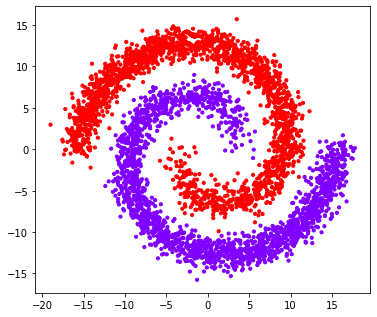

In [11]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

def get_spiral(num_samples):
    theta = np.sqrt(np.random.rand(num_samples)) * 2 * pi  # np.linspace(0,2*pi,100)

    r_a = 2 * theta + pi
    data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
    x_a = data_a + np.random.randn(num_samples, 2)

    r_b = -2 * theta - pi
    data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
    x_b = data_b + np.random.randn(num_samples, 2)

    res_a = np.append(x_a, np.zeros((num_samples, 1)), axis=1)
    res_b = np.append(x_b, np.ones((num_samples, 1)), axis=1)

    res = np.append(res_a, res_b, axis=0)
    np.random.shuffle(res)

    y_a = np.empty(x_a.shape[0])
    y_a.fill(0)
    y_b = np.empty(x_b.shape[0])
    y_b.fill(1)

    x = np.concatenate([x_a, x_b])
    y = np.concatenate([y_a, y_b])

    p = np.random.permutation(len(x))

    return x[p], y[p]

import matplotlib.pyplot as plot
from sklearn import cluster, datasets

samples, labels = get_spiral(2000)

plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.set_aspect(1.0)
ax.scatter(samples[:, 0], samples[:, 1], c=labels, cmap="rainbow", s=10)

#### 학습목표

* 점들을 n개의 클러스터로 분류하는 모델
* p1 p2 p3 p4 ... 점들이 어느 클러스터에 속하는지 포인트-클러스터 데이터셋을 준비한다.
* 학습 과정을 거친다. 어떤 모델(다중 신경망과 뉴럴네트워크,nn.linear, 비선형활성함수), optimizer, 오차 계산 알고리즘(그라디언트) epoch
  

In [12]:
def train(x, y, model, criterion, optimizer, num_epochs):

    # 전체 샘플을 train과 test로 나눠서 test는 훈련에 사용하지 않는다.
    # test는 model이 일반화가 잘 되었는지 확인하는 용도로 사용
    i_split = x.shape[0] // 10 # 전체의 10%는 test용으로 따로 분류
    x_train, x_test = x[i_split:], x[:i_split]
    y_train, y_test = y[i_split:], y[:i_split]

    loss_history = []
    train_accuracy_history = [] # 평가 기준에 정확도 추가
    test_accuracy_history = [] # 평가 기준에 정확도 추가

    for epoch in range(1, num_epochs + 1):
        optimizer.zero_grad()
        y_pre = model.forward(x_train)
        loss = criterion(y_pre, y_train)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        # train과 test 따로 분류 정확도 확인 forward와 argmax를 거친 값이 배열인가
        train_accuracy = model.forward(x_train).argmax(dim=1).eq(y_train).sum().item() / y_train.shape[0] * 100.0
        train_accuracy_history.append(train_accuracy)

        test_accuracy = model.forward(x_test).argmax(dim=1).eq(y_test).sum().item() / y_test.shape[0] * 100.0
        test_accuracy_history.append(test_accuracy)

        if epoch % (num_epochs // 5) == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}, accuracy = [{train_accuracy:.2f}, {test_accuracy:.2f}]")

    return loss_history, train_accuracy_history, test_accuracy_history


In [13]:
import torch

def visualize(model, samples, labels, loss_history, train_accuracy_history, test_accuracy_history):    

    plt.figure(figsize=(18, 6))

    ax131 = plt.subplot(131)
    ax131.set_aspect(1.0)
    ax131.scatter(samples[:, 0], samples[:, 1], c = labels, cmap="rainbow", s = 5)
    xl = ax131.get_xlim()
    yl = ax131.get_ylim()

    ax132 = plt.subplot(132)
    ax132.set_aspect(1.0)
    labels_pre = model(torch.tensor(samples, dtype=torch.float)).argmax(dim=1).detach().numpy()
    # 모델이 추측한 labels를 이용해서 샘플들의 색을 칠해준다.
    ax132.scatter(samples[:, 0], samples[:, 1], c = labels_pre, cmap="rainbow", s = 5)
    ax132.set_xlim(xl)
    ax132.set_ylim(yl)

    x_range = np.arange(xl[0], xl[1], 0.01)
    y_range = np.arange(yl[0], yl[1], 0.01)
    X, Y = np.meshgrid(x_range, y_range)
    xy = np.stack([X.flatten(), Y.flatten()], axis=1)
    Z = (
        model(torch.tensor(xy, dtype=torch.float))
        .argmax(dim=1)
        .detach()
        .numpy()
        .reshape(X.shape)
    )

    ax132.pcolormesh(X, Y, Z, cmap="rainbow", alpha = 0.2)

    ax1 = plt.subplot(133)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(loss_history, c = "r")
    ax2 = ax1.twinx()
    ax2.set_ylabel("Train accuracy (%)")
    ax2.plot(train_accuracy_history, c = "g")
    ax2.plot(test_accuracy_history, c = "b")


c:\miniconda3\envs\env_pytorch\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 100: loss = 0.00943997222930193, accuracy = [99.80, 99.80]
Epoch 200: loss = 0.004614557605236769, accuracy = [99.91, 100.00]
Epoch 300: loss = 0.0029202571604400873, accuracy = [99.93, 100.00]
Epoch 400: loss = 0.002381394850090146, accuracy = [99.94, 100.00]
Epoch 500: loss = 0.0020920035894960165, accuracy = [99.97, 100.00]


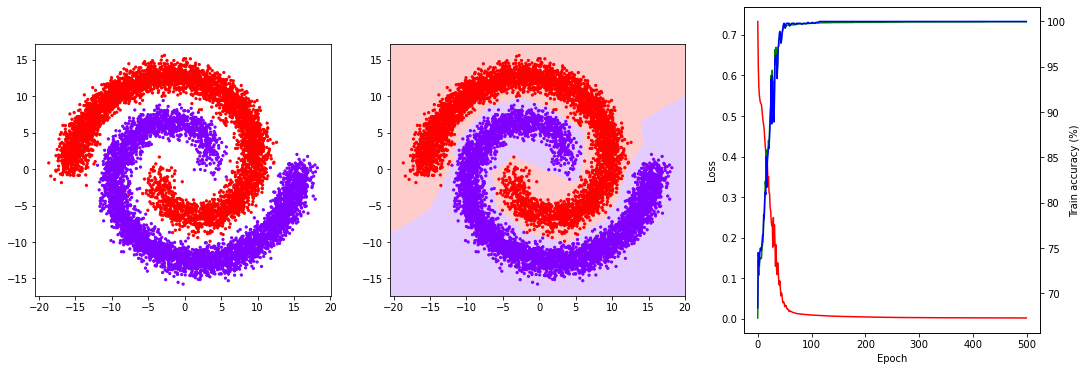

In [14]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
import torch.nn.functional as F


def visualize_graph(samples, labels, size):
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    ax.set_aspect(1.0)
    ax.scatter(samples[:, 0], samples[:, 1], c=labels, cmap="rainbow", s=size)

class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 =torch.nn.Linear(2, 10) # 첫번째 fully connected layer
        self.fc2 =torch.nn.Linear(10, 10)
        self.fc3 =torch.nn.Linear(10, 2) # 2개의 라벨을 출력하는 두번째 fully connected layer

    def forward(self, x): 
        # 데이터가 fc1을 지나갑니다.
        x = self.fc1(x)
        x = F.leaky_relu(x) 
        x = self.fc2(x)
        x = F.sigmoid(x) ##오!! 시그모이드 함수. 역전파시 음의 ...? 를 영으로 만들어 버릴 위험이 있는 렐루를 보완하기 위해..
        x = self.fc3(x)

        return x


samples, labels = get_spiral(5000)
#visualize_graph(samples, labels, size=1.5)


model = MyModel()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1) #왜 이거를 선택하는지도 모르겠고 각각의 알고리즘이 어떻게유도된건지도 정확히 모름

x = torch.tensor(samples, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

loss_history, train_acc_history, test_acc_history = train(x, y, model, criterion, optimizer, num_epochs=500)

visualize(model, samples, labels, loss_history, train_acc_history, test_acc_history)



* train 함수에 매개변수로 전달할 Model클래스를 정의한다
  * 생성자를 통해 다중계층 인공신경망을 만든다
    * nn.Linear, 비선형활성함수
    * 입력값은 x좌표와 y좌표로 2, 출력값은 두개의 클러스터 중 하나므로 2. 입력값과 출력값을 잘 맞추는 것이 결정적으로 중요하다 
  * train함수의 매개변수와 반환값. 함수니까. 제일 중요하다


```
loss.backward()
optimizer.step()
```

이 부분은 Model의 forward? backward? ?? 어떤 과정을 거치는지? epoch횟수만큼 loss를 구하고 backward한다.

아무리 큰 Linear Layer여러개를 조합해도 풀 수없다


In [15]:
class MyModel2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 =torch.nn.Linear(2, 10) # 첫번째 fully connected layer
        #self.fc2 =torch.nn.Linear(10, 10)
        self.fc2 =torch.nn.Linear(10, 2) # 2개의 라벨을 출력하는 두번째 fully connected layer

    def forward(self, x): 
        # 데이터가 fc1을 지나갑니다.
        x = self.fc1(x)
        x = F.leaky_relu(x) 
        x = self.fc2(x)
        #x = F.relu(x)
        #x = self.fc3(x)

        return x

Epoch 100: loss = 0.20260438323020935, accuracy = [89.33, 90.00]
Epoch 200: loss = 0.19943386316299438, accuracy = [89.44, 90.00]
Epoch 300: loss = 0.19623194634914398, accuracy = [90.56, 95.00]
Epoch 400: loss = 0.19517205655574799, accuracy = [90.00, 91.00]
Epoch 500: loss = 0.19567623734474182, accuracy = [90.00, 91.00]


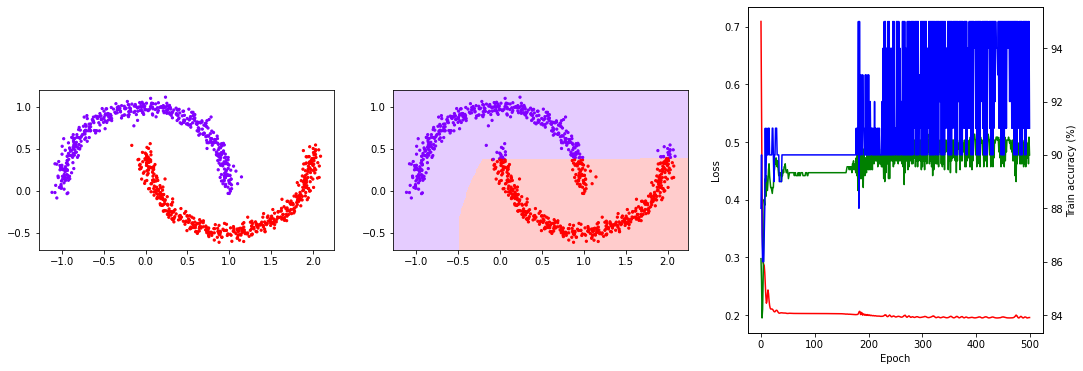

In [16]:
# make_moons 데이터세슬 분류하는 코드를 짜본다

import matplotlib.pyplot as plot
from sklearn import cluster, datasets

samples2, labels2 = datasets.make_moons(n_samples=1000, noise=0.05)

'''plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.set_aspect(1.0)
ax.scatter(samples[:, 0], samples[:, 1], c=labels, cmap="rainbow", s=5)
'''
model2 = MyModel2()

criterion2 = torch.nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-1) 

x2 = torch.tensor(samples2, dtype=torch.float)
y2 = torch.tensor(labels2, dtype=torch.long)

loss_history2, train_acc_history2, test_acc_history2 = train(x2, y2, model2, criterion2, optimizer2, num_epochs=500)

visualize(model2, samples2, labels2, loss_history2, train_acc_history2, test_acc_history2)